In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from core.koopman_core import KoopDNN,KoopmanNet,KoopmanNetCtrl
from models.koop_model import model_matricies,lift
from dynamics.duffing import dynamics_duff
from dynamics.Vanpol import dynamics_vanpol


In [2]:
# Base Parameters
dt = 0.01 #time step
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

In [3]:
file = 'saved_models/duff_best.pth'
model_koop_dnn = torch.load(file)

In [4]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)
n_lift = A.shape[0]
print(A.shape, B.shape, C.shape)

(13, 13) (13, 13) (2, 13)


In [5]:
class Dynamics:

    """
    this class defines the dynamics of a linear system

    """
    def __init__(self, A, B, C):
        """
        :param Ad: discrete drift matrix
        :param Bd: discrete activation matrix
        """
        self.A = A
        self.B = B
        self.C = C
        self.nz = A.shape[0]  # number of states
        self.nx = C.shape[0]
        self.m = int(B.shape[1]/self.nz)  #number of control signals

    def eval_dot(self, z, u, t = None):
        """
        computes z_k+1
        :param z: current state
        :param u: control input
        :return:
        """
        return self.A @ z + self.B @ np.kron(z, u)

    def get_linearization(self, z0, z1, u):
        """
        this computes the linearization matrix of the dynamics
        :return: A_lin, B_lin
        """

        A_lin = self.A.toarray() + self.B.toarray() @ np.kron(np.eye(self.nz), u.reshape((self.m, 1)))
        B_lin = self.B.toarray() @ np.kron(z0.reshape((self.nz, 1)), np.eye(self.m))

        z_next = self.eval_dot(z0, u)

        r_lin = z_next - z1

        return A_lin, B_lin, r_lin

In [1]:
from control.nmpc_osqp import NonlinearMPCController
import scipy

ModuleNotFoundError: No module named 'control.nmpc_osqp'

In [2]:
pip install control.nmpc_osqp

ERROR: Could not find a version that satisfies the requirement control.nmpc_osqp (from versions: none)
ERROR: No matching distribution found for control.nmpc_osqp
Note: you may need to restart the kernel to use updated packages.


In [17]:
bilinear_model = Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)

In [18]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [19]:
#Closed loop performance evaluation parameters:
traj_length = 2000
max_iter = 100
N = 5 #length of horizon
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = scipy.sparse.diags([10,10])                       # State penalty matrix, trajectory generation
QN_mpc = scipy.sparse.diags([1e3,1e3])         # Final state penalty matrix, trajectory generation
R_mpc = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = scipy.sparse.csc_matrix(np.zeros(num_inputs))

# Design trajectory:
x0 = np.array([-0.2, 0.1])                   # Initial value, closed loop trajectory
set_pt = np.array([0., 0.])              # Desired final value, closed loop trajectory
x_ref = np.tile(set_pt.reshape(-1,1), (1, traj_length))
xmax = np.array([5, 5])                          # State constraints, trajectory generation
xmin = -xmax
umax = 1
umin = -umax

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, x0, N+1)
u_init = 1*np.ones((num_inputs, N)).T

In [20]:
x_ref.shape

(2, 2000)

In [21]:
z_init = np.empty((N+1,n_lift))
z0 = lift(x0, model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)


In [22]:
controller_nmpc = NonlinearMPCController(bilinear_model, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc.construct_controller(z_init, u_init,x_ref[:,0])

In [23]:
controller_nmpc.trajectory_tracking(x0, z0, x_ref.T, max_iter)

time_step 0
time_step 1
time_step 2
time_step 3
time_step 4
time_step 5
time_step 6
time_step 7
time_step 8
time_step 9
time_step 10
time_step 11
time_step 12
time_step 13
time_step 14
time_step 15
time_step 16
time_step 17
time_step 18
time_step 19
time_step 20
time_step 21
time_step 22
time_step 23
time_step 24
time_step 25
time_step 26
time_step 27
time_step 28
time_step 29
time_step 30
time_step 31
time_step 32
time_step 33
time_step 34
time_step 35
time_step 36
time_step 37
time_step 38
time_step 39
time_step 40
time_step 41
time_step 42
time_step 43
time_step 44
time_step 45
time_step 46
time_step 47
time_step 48
time_step 49
time_step 50
time_step 51
time_step 52
time_step 53
time_step 54
time_step 55
time_step 56
time_step 57
time_step 58
time_step 59
time_step 60
time_step 61
time_step 62
time_step 63
time_step 64
time_step 65
time_step 66
time_step 67
time_step 68
time_step 69
time_step 70
time_step 71
time_step 72
time_step 73
time_step 74
time_step 75
time_step 76
time_step

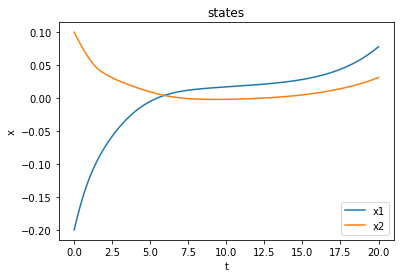

In [24]:
plt.figure()
plt.plot(t_eval, controller_nmpc.x_traced[:,0],label ='x1')
plt.plot(t_eval, controller_nmpc.x_traced[:,1],label = 'x2')
plt.xlabel('t')
plt.ylabel('x')
plt.title('states')
plt.legend()
plt.show()

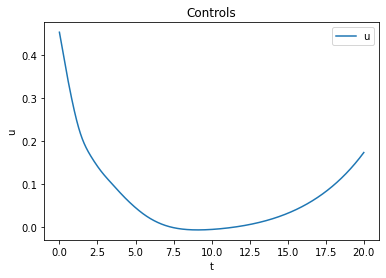

In [25]:
plt.figure()
plt.plot(t_eval[:-1], controller_nmpc.controls,label ='u')
plt.xlabel('t')
plt.ylabel('u')
plt.title('Controls')
plt.legend()
plt.show()